# Solving Burgers Equation Using a Fully Connected NN 

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial u^2}{\partial x^2}
$$

## Description: 

Inner PDE is referring to the matching of the time differential operator to the space operators, basically by minimizing the MSE in the equation of: 

$$
\frac{\partial u}{\partial t} = - u\frac{\partial u}{\partial x} + \nu \frac{\partial u^2}{\partial x^2}
$$

<hr>

<hr> 

Imports: 

In [41]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch 
import torchvision 
from torch import nn
import tqdm
import torch.nn.functional as F 
from matplotlib import pyplot as plt
from math import floor, ceil

import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import glob
from PIL import Image
from torchvision import transforms
from sklearn import preprocessing
import time

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Data:

In [44]:
# Turn .mat file into dictionary
def add_todict(matobj):
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, sio.matlab.mio5_params.mat_struct):
            dict[strg] = add_todict(elem)
        else:
            dict[strg] = elem
    return dict

def convert_to_dictonary(dict):
    for key in dict:
        if isinstance(dict[key], sio.matlab.mio5_params.mat_struct):
            dict[key] = add_todict(dict[key])
    return dict

data = sio.loadmat('/content/drive/MyDrive/PDE_NNets/Data/Burgers/FC_gaussian_data.mat', struct_as_record=False, squeeze_me=True)
data_dict = convert_to_dictonary(data)

u = data_dict['u'];
x = data_dict['x'];
t = data_dict['t'];

print("u shape:", np.shape(u))
print("x shape:", np.shape(x))
print("t shape:", np.shape(t))

# Meshgrid of inputs
N = len(x)
X, T = np.meshgrid(x, t)
Xvec = X.reshape(N**2, 1)
Tvec = T.reshape(N**2, 1)

nu = 0.2

u shape: (201, 201)
x shape: (201,)
t shape: (201,)


### Building Data for IC, BC, and inner PDE behavior 

IC: 

In [74]:
def IC(Xinp):
  Xinp = Xinp.reshape(len(Xinp), )
  u0 = np.zeros(Xinp.shape)

  u0 = np.exp(-(2*(Xinp)**2))

  return u0 

In [77]:
# IC
def get_IC(): 
  # u0 = u[:, 0]
  u0 = IC(Xvec)
  u0 = np.expand_dims(u0, axis=1)
  X_ic = np.column_stack((Xvec, np.zeros(Xvec.shape)))

  # plt.plot(u0)
  # print(u0.shape)

  X_ic = torch.from_numpy(X_ic).type(torch.Tensor)
  u0 = torch.from_numpy(u0).type(torch.Tensor)
  
  return X_ic.to(device), u0.to(device)

_, _ = get_IC()

BC:

In [47]:
# u = 0 at x = 0 and u = 0 at x = end 
def get_BC():
  X_left = np.column_stack((np.zeros(Xvec.shape), Tvec))
  X_right = np.column_stack((np.zeros(Xvec.shape), Tvec))

  X_left = torch.from_numpy(X_left).type(torch.Tensor)
  X_right = torch.from_numpy(X_right).type(torch.Tensor)

  return X_left.to(device), X_right.to(device)

Inner PDE:

In [48]:
X_train = np.column_stack((Xvec, Tvec))
X_train = torch.from_numpy(X_train).type(torch.Tensor).to(device)

### Building Network: 

In [49]:
class Network(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, 1024)
    self.layer2 = nn.Linear(1024, 2048)
    self.layer3 = nn.Linear(2048, 2048)
    self.layer4 = nn.Linear(2048, 1024)
    self.layer5 = nn.Linear(1024, 512)
    self.layer6 = nn.Linear(512, 256)
    self.layer7 = nn.Linear(256, 1)

  def forward(self, x):
    out = torch.relu(self.layer1(x))
    out = torch.relu(self.layer2(out))
    out = torch.relu(self.layer3(out))
    out = torch.relu(self.layer4(out))
    out = torch.relu(self.layer5(out))
    out = torch.relu(self.layer6(out))

    out = self.layer7(out)

    return out

### Training Network

In [87]:
 # Creating Model
model = Network(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200
loss_fn = torch.nn.MSELoss()

total_losses = []
ic_losses = []
bc_losses = [] 
inner_losses = []
for epoch in range(num_epochs):

  # inner pde 
  X_train.requires_grad_(True)
  u_pred = model(X_train).to(device)

  grads, = torch.autograd.grad(outputs=u_pred, inputs=X_train, grad_outputs=u_pred.data.new(u_pred.shape).fill_(1), create_graph=True, only_inputs=True)
  dudx = grads[:, 0]
  dudt = grads[:, 1]

  grads_double, = torch.autograd.grad(outputs=dudx, inputs=X_train, grad_outputs=dudx.data.new(dudx.shape).fill_(1), create_graph=True, only_inputs=True)
  dudxx = grads_double[:, 0]

  u_pred = u_pred.reshape(N**2,)
  inner_loss = loss_fn(dudt, -(u_pred * dudx) + nu*dudxx)

  # inital condition 
  X_ic, u0 = get_IC()
  u_pred = model(X_ic).to(device)

  ic_loss = loss_fn(u_pred, u0)

  # boundary conditions 
  X_left, X_right = get_BC()
  u_left = model(X_left).to(device)
  u_right = model(X_right).to(device)

  bc_loss = loss_fn(u_left, u_right)

  # Updating
  optimizer.zero_grad()
  loss = inner_loss + ic_loss + bc_loss
  loss.backward()
  optimizer.step()

  total_losses.append(loss.item())
  ic_losses.append(ic_loss.item())
  bc_losses.append(bc_loss.item())
  inner_losses.append(inner_loss.item())

  if epoch % 25 == 0:
    print("Epoch:", epoch, "    IC Loss:        ", ic_loss.item())
    print("Epoch:", epoch, "    Inner PDE Loss: ", inner_loss.item())
    print("Epoch:", epoch, "    BC Loss:        ", bc_loss.item())
    print("Epoch:", epoch, "    Total Loss:     ", loss.item(), "\n")

print("\nFinal Training Loss:", loss.item(),"\n")

Epoch: 0     IC Loss:         0.042358625680208206
Epoch: 0     Inner PDE Loss:  5.9522894844121765e-06
Epoch: 0     BC Loss:         0.0
Epoch: 0     Total Loss:      0.04236457869410515 

Epoch: 25     IC Loss:         0.004706615582108498
Epoch: 25     Inner PDE Loss:  0.001001438358798623
Epoch: 25     BC Loss:         0.0
Epoch: 25     Total Loss:      0.005708053708076477 

Epoch: 50     IC Loss:         0.0007330508669838309
Epoch: 50     Inner PDE Loss:  0.0010746087646111846
Epoch: 50     BC Loss:         0.0
Epoch: 50     Total Loss:      0.0018076596315950155 

Epoch: 75     IC Loss:         0.0003107975353486836
Epoch: 75     Inner PDE Loss:  0.001179416198283434
Epoch: 75     BC Loss:         0.0
Epoch: 75     Total Loss:      0.0014902136754244566 

Epoch: 100     IC Loss:         0.0008844060357660055
Epoch: 100     Inner PDE Loss:  0.0010399725288152695
Epoch: 100     BC Loss:         0.0
Epoch: 100     Total Loss:      0.001924378564581275 

Epoch: 125     IC Loss:    

Plotting Training Losses 

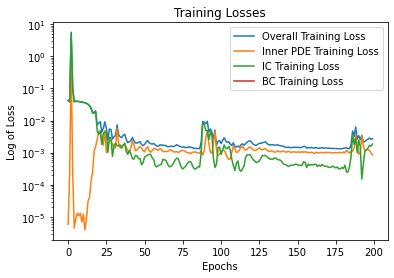

In [91]:
# Plotting Losses
plt.plot(total_losses, label="Overall Training Loss")
plt.plot(inner_losses, label="Inner PDE Training Loss")
plt.plot(ic_losses, label="IC Training Loss")
plt.plot(bc_losses, label="BC Training Loss")
plt.yscale('log')

plt.title("Training Losses")
plt.ylabel("Log of Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

Plotting Solution:

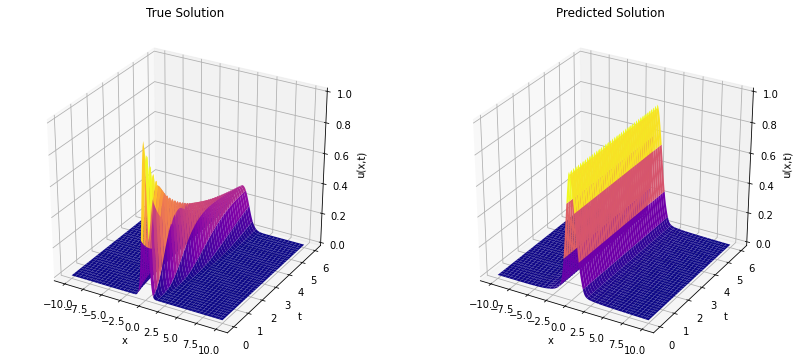

In [89]:
# Plotting Predicted vs. True Solution 
u = data_dict['u'];
x = data_dict['x'];
t = data_dict['t'];

xspan, tspan = np.meshgrid(x, t)
u_true = u
fig = plt.figure(figsize=(14, 6))


# True solution plot 
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(xspan, tspan, u_true.T, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title("True Solution\n\n")


# Predicted solution plot 
Upred = u_pred.detach().cpu().numpy().reshape(N, N)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(xspan, tspan, Upred, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_zticks(np.linspace(0, 1, 6))
ax.set_title("Predicted Solution\n\n")

plt.show()